# Milano Location History 

The goal of this post is to visualize time spent in various Milanesi neighborhoods using Google location data and Python
* This post utilizes code from Tyler Hartley's [visualizing location history blog post](http://beneathdata.com/how-to/visualizing-my-location-history/) 

# Overview 

1. Setup
    * download data
    * install modules
2. Data wrangling
    * data extraction
    * data exploration
3. Working with Shapefiles in Python
4. Prep data and pare down locations
5. Compute your measurement metric
4. Choropleth Plot
5. Hexbin Map

# Setup
1. Use Google Takout to download your Google location history
* If you've previously enabled Google location reporting on your smartphone, your GPS data will be periodically uploaded to [Google's servers](https://support.google.com/accounts/answer/3118687?hl=en&visit_id=1-636109809748631344-4285616029&rd=1). Use Google Takeout to download your location history.
    * The decisions of when and how to upload this data are entirely obfuscated to the end user, but as you'll see below, Android appears to upload a GPS location every 60 seconds. That's plenty of data to work with.
2. After downloading your data, install the required modules

## Google Takeout
Google [Takeout](https://takeout.google.com/settings/takeout) is a Google service that allows users to export any personal Google data. We'll use Takeout to download our raw location history as a one-time snapshot. Since Latitude was retired, no API exists to access location history in real-time. 

Download location data:
* Go to [takeout](https://www.google.com/settings/takeout). Uncheck all services except "Location History" 
* The data will be in a json format, which works great for us. Download it in your favorite compression type.
* When Google has finished creating your archive, you'll get an email notification and a link to download. 
* Download and unzip the file, and you should be looking at a `LocationHistory.json` file. Working with location data in [Pandas](http://pandas.pydata.org/). Pandas is an incredibly powerful tool that simplifies working with complex datatypes and performing statistical analysis in the style of R. Chris Albon has great primers on using Pandas [here](http://chrisalbon.com/#Python) under the "Data Wrangling" section.

## Install modules
* If you use Anaconda to manage your Python packages, I recommend creating a virtual environment with anaconda to install the dependencies. Copying the lines below the instruction into the terminal creates the environment, requirements.txt, etc.
    * conda create -n test-env python=3.5 anaconda
    * source activate test-env
* make a requirements.txt file for dependencies 
    * (echo descartes; echo IPython; echo shapely; echo fiona; echo Basemap) >> requirements.txt  
* install requirements.txt
    * conda install --yes --file requirements.txt
* Windows users:
    * create a python2.7 environment to install relevant modules
        * conda create -n py27 python=2.7 anaconda
        * source activate py27
    * Download and install [Microsoft Visual C++ Compiler for Python 2.7 ](https://www.microsoft.com/EN-US/DOWNLOAD/DETAILS.ASPX?ID=44266)
    * pysal from https://www.lfd.uci.edu/~gohlke/pythonlibs/

After completing the setup, we'll read in the `LocationHistory.json` file from Google Takeout and create a DataFrame.

In [1]:
from __future__ import division
from utils import * 

# Data Wrangling
* data extraction

In [2]:
with open('data/LocationHistory/2018/LocationHistory.json', 'r') as location_file:
    raw = json.loads(location_file.read())

# use location_data as an abbreviation for location data
location_data = pd.DataFrame(raw['locations'])
del raw #free up some memory

# convert to typical units
location_data['latitudeE7'] = location_data['latitudeE7']/float(1e7) 
location_data['longitudeE7'] = location_data['longitudeE7']/float(1e7)

# convert timestampMs to seconds
location_data['timestampMs'] = location_data['timestampMs'].map(lambda x: float(x)/1000) 
location_data['datetime'] = location_data.timestampMs.map(datetime.datetime.fromtimestamp)

# Rename fields based on the conversions
location_data.rename(columns={'latitudeE7':'latitude',
                              'longitudeE7':'longitude',
                              'timestampMs':'timestamp'}, inplace=True)

# Ignore locations with accuracy estimates over 1000m
location_data = location_data[location_data.accuracy < 1000]
location_data.reset_index(drop=True, inplace=True)

## Explore Data
* view data and datatypes

In [3]:
print(location_data.dtypes)
location_data.describe()

accuracy                     int64
activity                    object
altitude                   float64
heading                    float64
latitude                   float64
longitude                  float64
timestamp                  float64
velocity                   float64
verticalAccuracy           float64
datetime            datetime64[ns]
dtype: object


accuracy       altitude       heading       latitude  \
count  745660.000000  101260.000000  44100.000000  745660.000000   
mean       58.997173      67.057525    186.597551      37.748367   
std       125.358984     242.209547    101.643968       9.004123   
min         1.000000    -715.000000      0.000000      13.689757   
25%        22.000000     -18.000000     98.000000      29.817569   
50%        31.000000       2.000000    181.000000      29.986634   
75%        50.000000      60.000000    270.000000      47.664284   
max       999.000000    6738.000000    359.000000      50.105984   

           longitude     timestamp      velocity  verticalAccuracy  
count  745660.000000  7.456600e+05  58874.000000       4921.000000  
mean     -102.506537  1.417774e+09      7.769678         23.099776  
std        23.609836  3.356510e+07     11.790783         45.139324  
min      -123.260751  1.376790e+09      0.000000          2.000000  
25%      -122.306596  1.391259e+09      0.000000          2.000000  
50%       -95.246060  1.413249e+09      1.000000          2.000000  
75%       -94.995603  1.428049e+09     13.000000         30.000000  
max        23.782015  1.519330e+09    208.000000        473.000000

* accuracy code "999" may represent missingness  
* find earliest and latest observations in the data
    * save for later

In [4]:
print("earliest observed date: {}".format(min(location_data["datetime"]).strftime('%m-%d-%Y')))
print("latest observed date: {}".format(max(location_data["datetime"]).strftime('%m-%d-%Y')))

earliest_obs = min(location_data["datetime"]).strftime('%m-%d-%Y')
latest_obs = max(location_data["datetime"]).strftime('%m-%d-%Y')

earliest observed date: 08-17-2013
latest observed date: 02-22-2018


* `location_data` is a Pandas DataFrame containing all your location history and related info. 
* columns include latitude, longitude, and a timestamp. additional columns are accuracy, activity, altitude, heading, and velocity. 
* all we'll need is latitude, longitude, and time.



# Working with Shapefiles in Python

[Shapefile](https://en.wikipedia.org/wiki/Shapefile) is a widely-used data format for describing points, lines, and polygons. To work with shapefiles, Python gives us [`shapely`](https://pypi.python.org/pypi/Shapely). To read and write shapefiles, we'll use [`fiona`](https://pypi.python.org/pypi/Fiona).

To learn Shapely and write this blog post, I leaned heavily on [this article](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.WZsuZ5OGP_S) from [sensitivecities.com](http://www.sensitivecities.com). 

First up, you'll need to download shapefile data for the part of the world you're interested in plotting. I wanted to focus on my current home of Milano, which like many cities provides [city shapefile map data for free](https://geoportale.comune.milano.it/sit/open-data/). It's even broken into city neighborhoods!  Tom MacWright has [GIS with Python, Shapely, and Fiona](https://macwright.org/2012/10/31/gis-with-python-shapely-fiona.html) overview for more detail on Python mapping with these tools

Next, we'll need to import the Shapefile data we downloaded from the geoportale.comune.milano.it link above


* used the steps suggested in this post to save the Milano.shp file CRS system to WGS84
    + [http://fascicul.us/convert-display-shapefile-matplotlib.html](http://fascicul.us/convert-display-shapefile-matplotlib.html)

In [5]:
shapefilename = "data/Milano/Milano"
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
shp.close()

width, height = coords[2]- coords[0], coords[3] - coords[1]
extra = 0.01

* Use Basemap to plot the shapefiles

In [6]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * width,
    llcrnrlat=coords[1] - (extra * height), 
    urcrnrlon=coords[2] + extra * width,
    urcrnrlat=coords[3] + (extra * height),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='milano', drawbounds=False, color='none', zorder=2)

# Prep data and pare down locations
The first step is to pare down your location history to only contain points within the map's borders.


In [7]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.milano],
    'name': [hood['NIL'] for hood in m.milano_info]
})

# Convert our latitude and longitude into Basemap cartesian map coordinates
mapped_points = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(location_data['longitude'], 
            location_data['latitude'])]
all_points = MultiPoint(mapped_points)

# Use prep to optimize polygons for faster computation
hood_polygons = (MultiPolygon(list(df_map['poly'].values)))
prepared_polygons = prep(hood_polygons)

# Filter out the points that do not fall within the map we're making
city_points_filter = filter(prepared_polygons.contains, all_points)
city_points_list = list(city_points_filter)

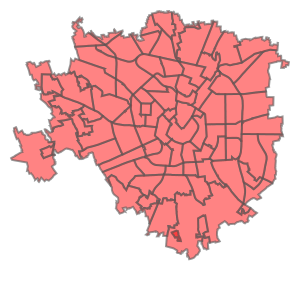

In [8]:
hood_polygons

In [9]:
df_map.tail()

name                                               poly
84              TICINESE  POLYGON ((11630.09398147638 7450.375391480873,...
85             CANTALUPA  POLYGON ((9103.651029835517 3586.401798879733,...
86     PARCO DEI NAVIGLI  POLYGON ((8963.725031880311 3321.837383000022,...
87                PAGANO  POLYGON ((9933.632072928249 9060.827339615005,...
88  GARIBALDI REPUBBLICA  POLYGON ((12564.62148112342 11062.39099056072,...

In [10]:
print("total data points in this period: {}".format(len(all_points)))
print("total data points in the city shape file for this period: {}".format(len(city_points_list)))
percentage_in_city = round(len(city_points_list)/len(all_points),2)*100
print("{}% of points this period are in the city shape file".format(percentage_in_city))

total data points in this period: 745660
total data points in the city shape file for this period: 14231
2.0% of points this period are in the city shape file


Now, city_points contains a list of all points that fall within the map and hood_polygons is a collection of polygons representing, in my case, each neighborhood in Milano.

#  Compute your measurement metric
The raw data for my choropleth should be "number of points in each neighborhood." With Pandas, again, it's easy. (Warning - depending on the size of the city_points array, this could take a few minutes.)

* view most popular neighborhoods by counts

In [11]:
df_map['hood_count'] = df_map['poly'].map(lambda x: num_of_contained_points(x, city_points_list))
df_map['hood_hours'] = df_map.hood_count/60.0

In [12]:
df_map.sort_values(['hood_count'], ascending=[0]).head()

name                                               poly  \
21     EX OM - MORIVIONE  POLYGON ((12701.8400366421 5749.665425603603, ...   
83             VIGENTINA  POLYGON ((12395.06694475143 7416.000147188619,...   
32             GUASTALLA  POLYGON ((13179.99521035373 9628.809211483189,...   
34                 DUOMO  POLYGON ((11199.51571519782 9304.427052039622,...   
36  MAGENTA - S. VITTORE  POLYGON ((10933.59503462748 9188.373696373419,...   

    hood_count  hood_hours  
21        5961   99.350000  
83        3087   51.450000  
32        2599   43.316667  
34         603   10.050000  
36         476    7.933333

In [13]:
morivione_points = round(len(list(filter((df_map['poly'][21]).contains, city_points_list)))/len(city_points_list),2)*100
print("{}% of points this in the city shape file are from the {}".format(morivione_points, df_map['name'][21]))

42.0% of points this in the city shape file are from the EX OM - MORIVIONE


So now, df_map.hood_count contains a count of the number of GPS points located within each neighborhood. But what do those counts really mean? It's not very meaningful knowing that I spent any n "counts" in a neighborhood, except to compare neighborhood counts against each other. And we could do that. Or we could convert hood_count into time

Turns out, converting counts into time is straightforward. From investigating the location history, it seems that unless the phone is off or without reception, Android reports you location exactly every 60 seconds. Not usually 60 seconds, not sometimes 74 seconds, every 60 seconds. It's been true on Android 4.2+. Hopefully that means it holds true for you, too. So if we make the assumption that my phone is on 24/7 (true) and I have city-wide cellular reception (also true), then all we need to do is hood_count/60.0, as shown above, and now we've converted counts to hours.

#  Choropleth Plot
* The code for creating this hexbin map below is in `choropleth.py`

In [14]:
if not os.path.exists('output/milano_plots'):
    os.makedirs('output/milano_plots')

hexbin_file = 'milano_hexbin'
choropleth_file = 'milano_choropleth'

In [15]:
#%run choropleth.py

In [16]:
# Check out the full post at http://beneathdata.com/how-to/visualizing-my-location-history/
# for more information on the code below

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

breaks = Natural_Breaks(
    df_map[df_map['hood_hours'].notnull()].hood_hours.values,
    initial=300,
    k=4)

# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['hood_hours'].notnull()].index)
df_map['jenks_bins'] = jb
df_map.jenks_bins.fillna(-1, inplace=True)
jenks_labels = ['Never been here', "> 0 hours"]+["> %d hours"%(perc) for perc in breaks.bins[:-1]]



cmap = plt.get_cmap('Blues')

# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)

# Draw a map scale
m.drawmapscale(coords[0] + 0.12, coords[1]-.002,
    coords[0], coords[1], 4., units='mi',
    fontsize=12, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000', fontcolor='#555555',
    zorder=5, ax=ax)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=15)

current_date = time.strftime("printed: %a, %d %b %Y", time.localtime())

ax.set_title("Time Spent in Milanesi Neighborhoods",
             fontsize=14, y=1)
ax.text(1.35, -.18, "kivanpolimis.com", color='#555555', fontsize=15, ha='right', transform=ax.transAxes)
ax.text(1.35, -.21, "Collected from {} to {} on Android".format(earliest_obs, latest_obs),
        fontsize=12, ha='right', transform=ax.transAxes)  
ax.text(1.35, -.27, "Geographic data provided by: \n https://geoportale.comune.milano.it \n  {}".format(current_date), 
        ha='right', color='#555555', style='italic', transform=ax.transAxes)
plt.savefig('output/milano_plots/{}.png'.format(choropleth_file), dpi=100, frameon=False,
            bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

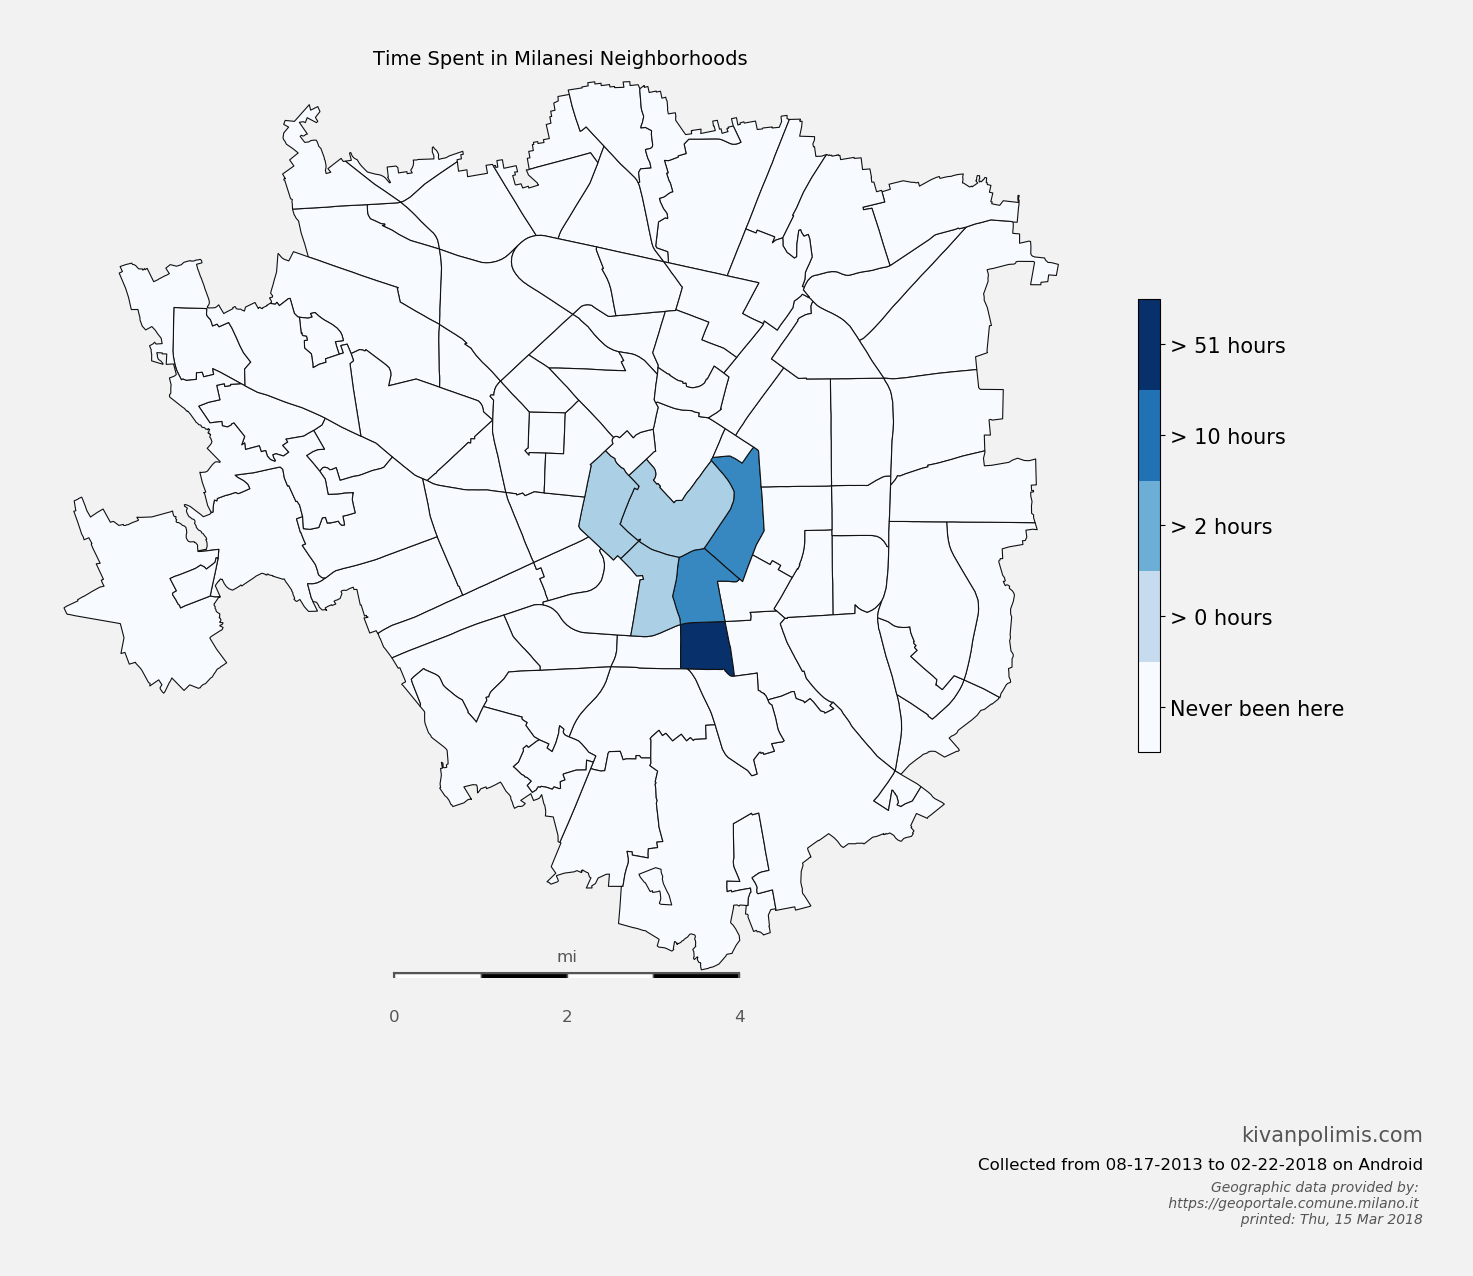

In [17]:
Image("output/milano_plots/{}.png".format(choropleth_file))

# Hexbin Map
We can also take a different approach to choropleths, and instead of using each neighborhood polygon as a bin, let Basemap generate uniform hexagonal bins for us. Hexbin maps are great way to visualize point density because all bins are equally sized. Best of all, it requires essentially no extra work as we've already defined our neighborhood Patches and paired down our location data. The code for creating this hexbin map below is in `hexbin.py`

In [18]:
#%run hexbin.py

In [19]:
"""PLOT A HEXBIN MAP OF A LOCATION
"""

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw neighborhood patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#555555', lw=1, alpha=1, zorder=0))

# plot neighborhoods by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# the mincnt argument only shows cells with a value >= 1
# The number of hexbins you want in the x-direction
numhexbins = 50
hx = m.hexbin(
    np.array([geom.x for geom in city_points_list]),
    np.array([geom.y for geom in city_points_list]),
    gridsize=(numhexbins, int(numhexbins*height/width)), #critical to get regular hexagon, must stretch to map dimensions
    bins='log', mincnt=1, edgecolor='none', alpha=1.,
    cmap=plt.get_cmap('Blues'))

# Draw the patches again, but this time just their borders (to achieve borders over the hexbins)
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='none', ec='#FFFF99', lw=1, alpha=1, zorder=1))
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# Draw a map scale
m.drawmapscale(coords[0] + 0.05, coords[1] + 0.01,
    coords[0], coords[1], 4.,
    units='mi', barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5)

ax.set_title("My location density in Milano", fontsize=14, y=1)
ax.text(1.35, -.06, "kivanpolimis.com", color='#555555', fontsize=14, ha='right', transform=ax.transAxes)
ax.text(1.35, -.09, "Collected from {} to {} on Android".format(earliest_obs, latest_obs),
        fontsize=12, ha='right', transform=ax.transAxes)  
ax.text(1.35, -.15, "Geographic data provided by: \n https://geoportale.comune.milano.it \n  {}".format(current_date), 
        ha='right', color='#555555', style='italic', transform=ax.transAxes)
plt.savefig('output/milano_plots/{}.png'.format(hexbin_file), dpi=100, frameon=False,
            bbox_inches='tight', pad_inches=0.5, facecolor='#DEDEDE')

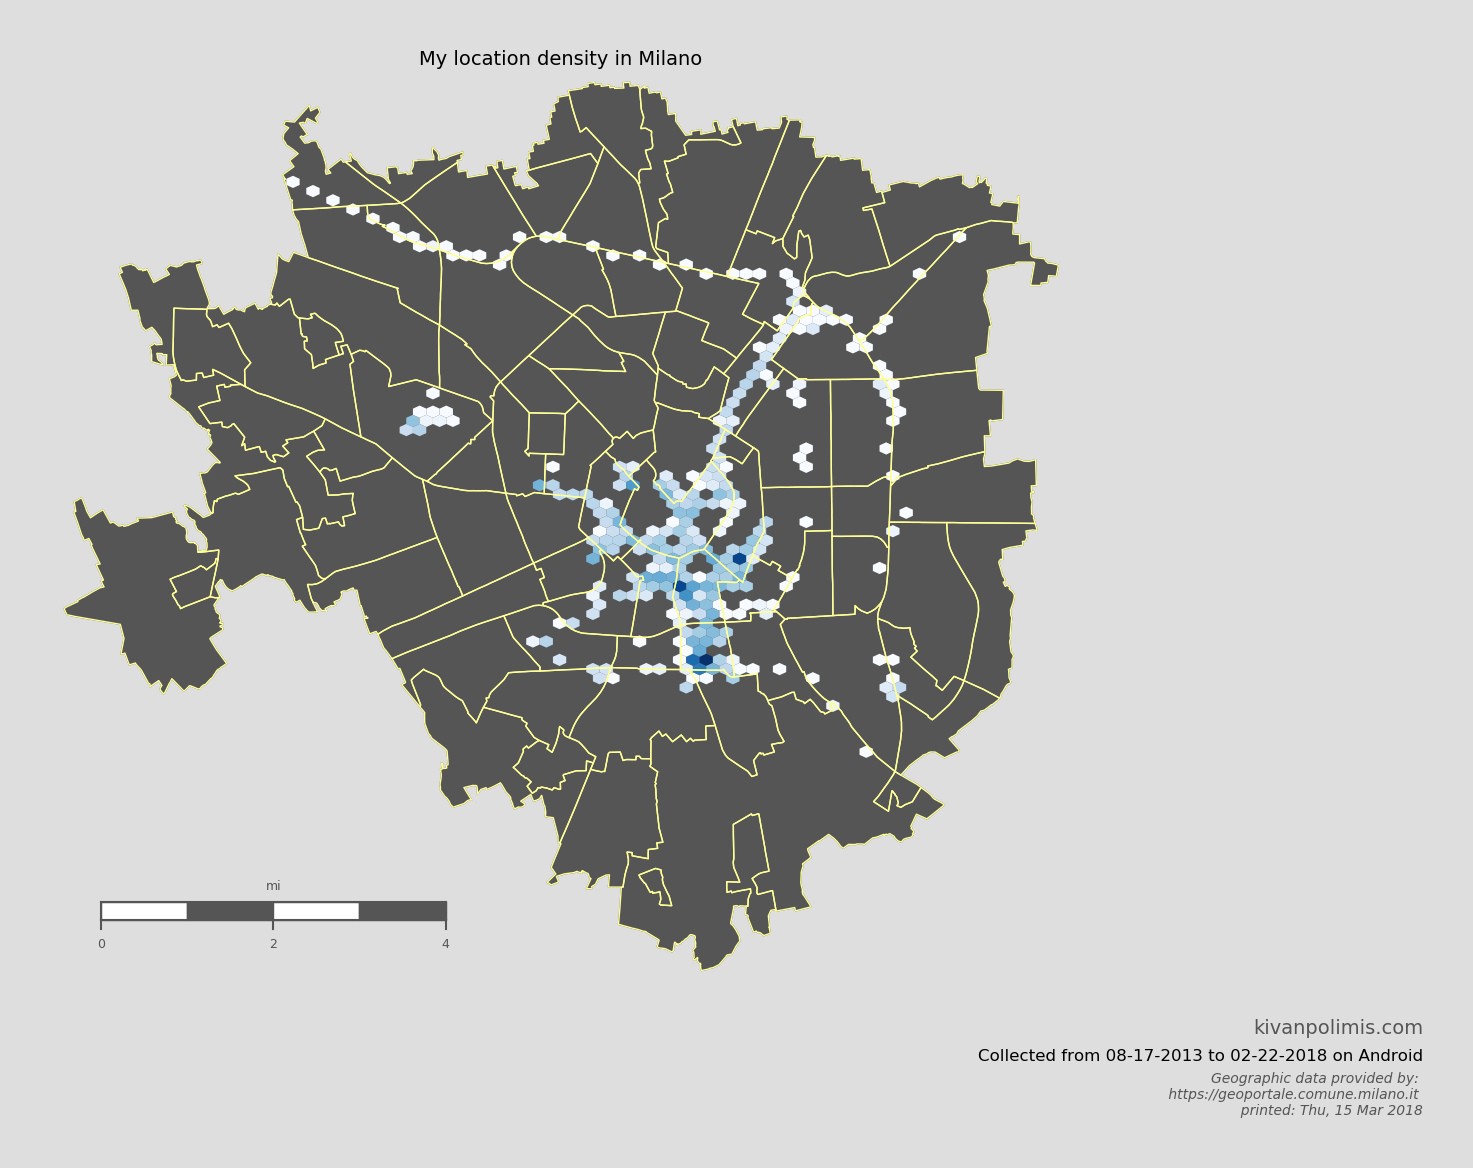

In [20]:
Image("output/milano_plots/{}.png".format(hexbin_file))

## Potential future directions
* Figure out where you usually go on the weekends
* Investigate your commute time by day of the week
* measure the amount of time you spend driving vs. walking vs. biking

Download this [notebook](downloads/notebooks/milano_location_history.ipynb), or see a static view [here](https://github.com/kpolimis/kpolimis.github.io/blob/master/downloads/notebooks/milano_location_history.ipynb)

In [21]:
print("System and module version information: \n")
print('Python version: \n {} \n'.format(sys.version_info))
print("last updated: {}".format(time.strftime("%a, %d %b %Y %H:%M", time.localtime())))

System and module version information: 

Python version: 
 sys.version_info(major=2, minor=7, micro=14, releaselevel='final', serial=0) 

last updated: Thu, 15 Mar 2018 05:00
